# Zonally Averaged Overturning Circulation

This notebook shows a simple example of calculation the zonally averaged global meridional overturning circulation - in density space.

**Requirements:** The `conda/analysis3-20.01` (or later) module on the VDI (or your own up-to-date cookbook installation).

**Firstly,** load in the requisite libraries:

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client

In [2]:
client = Client(n_workers=4)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:45635 Dashboard: /proxy/35685/status,Cluster Workers: 4 Cores: 48 Memory: 202.49 GB


**Next,** choose an experiment. This can be any resolution, and can be with or without Gent-McWilliams eddy parameterisation. In this case, we are choosing to limit ourselves to just the last 60 years of the chosen simulation.

In [3]:
expt = '025deg_jra55v13_iaf_gmredi6'
session = cc.database.create_session()
start_time='2198-01-01'

Load up `ty_trans_rho` - and sum zonally.
Also, if there is a `ty_trans_rho_gm` variable saved, assume that GM is switched on and load that as well. 

In [4]:
psi = cc.querying.getvar(expt,'ty_trans_rho',session,start_time = start_time)
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_rho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time)
    psiGM = psiGM.sum('grid_xt_ocean')
else:
    GM = False

Most ACCESS-OM2 simulations save transport with units of kg/s - convert to Sv:

In [5]:
psi = psi*1.0e-9
if GM:
    psiGM = psiGM*1.0e-9

Now, cumulatively sum the transport in the vertical. Note that in MOM5 the `ty_trans_rho_GM` variable is computed differently and **does not** require summing in the vertical. Once the calculation has been laid out, we then load the variable to force the computation to occur.

In [6]:
psi_avg = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
if GM:
    psi_avg = psi_avg + psiGM.mean('time')
    
psi_avg.load()

<xarray.DataArray (potrho: 80, grid_yu_ocean: 1080)>
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.1407325e-03, -1.0217292e-02, -6.7212423e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.5593946e-03, -1.0496276e-02, -6.9975522e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -8.9575853e-03, -1.0793662e-02, -7.1885712e-03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  2.3283064e-10, -1.4551915e-11],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  2.3283064e-10, -1.4551915e-11],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  2.3283064e-10, -1.4551915e-11]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.89 90.0

Now we are ready to plot. We usually plot the streamfunction over a reduced range of density levels to highlight the deep ocean contribution...

Text(0.5, 1.0, 'Overturning in 025deg_jra55v13_iaf_gmredi6')

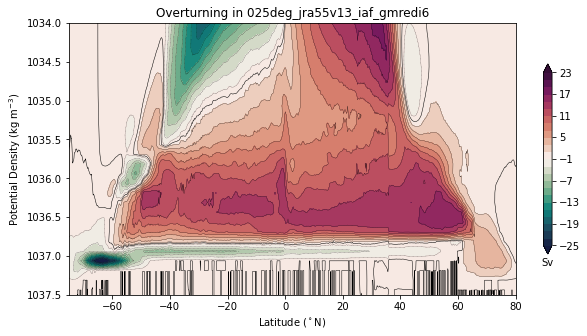

In [7]:
plt.figure(figsize=(10, 5)) 
clev = np.arange(-25,25,2)
plt.contourf(psi_avg.grid_yu_ocean,psi_avg.potrho, psi_avg, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Overturning in %s' % expt)

Alternatively, you may want to stretch your axes to minimise the visual impact of the surface circulation, while showing the full-depth ocean.

Text(0.5, 1.0, 'Overturning in 025deg_jra55v13_iaf_gmredi6')

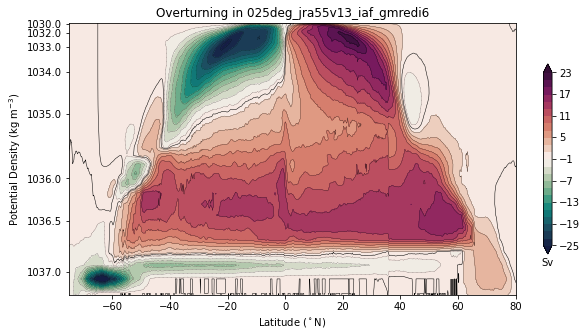

In [8]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
p1=ax.contourf(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
ax.contour(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, levels=clev, colors='k', linewidths=0.25)
ax.contour(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)

ax.set_yticks((yticks-1028)**scfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**scfac, 9.2**scfac])
ax.invert_yaxis()
ax.set_ylabel('Potential Density (kg m$^{-3}$)')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_xlim([-75,80])
ax.set_title('Overturning in %s' % expt)

**Notes:**
 * We have not included the submesoscale contribution to the meridional transport in these calculations, as it tends to be relatively unimportant for the deep circulation, which we where we are primarily interested.
 * These metrics do not use mathematically correct zonal averaging in the tripole region, north of 65°N. 